# Utilities for Managing Training Data & Routines

This notebook is responsible for writing out `training_utils.py` which is then imported in other notebooks to manage training data and/or execute training routines.  There are methods to create train & test `tf.data.Dataset`'s, as well as methods for printing classification reports and confusion matrices after training.

The rest of the notebook is either for testing these routines, or using them to write out data in other formats.  The two things it writes out are:

1. Features extracted from Xception network for all source images, so that we can try sklearn classification methods without any image loading or processing
2. Testing directories for the final executable model, to test that it reads, resizes, rotates, and classifies images properly.

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc

from load_and_preprocess_data import TrainDataInfo

In [4]:
%load_ext autoreload
%autoreload 2

In [10]:
%%writefile training_utils.py
import cv2
import os
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from load_and_preprocess_data import TrainDataInfo
from image_utilities import ImageUtilities
from matplotlib.ticker import MaxNLocator

# This is a wrapper that holds a TrainDataInfo object, implements some useful methods with it
class TrainingUtils:
    def __init__(self, all_train_info, img_size_3d, batch_size):
        self.train_info = all_train_info
        self.num_countries = len(all_train_info.country_names)
        csizes =  [len(all_train_info.filename_map[c]) for c in all_train_info.country_names]
        self.total_file_count = sum(csizes)
        self.img_size_3d = img_size_3d
        self.img_size_2d = img_size_3d[:2]
        self.batch_size = batch_size
        
        
    def indices_to_labels(self, y_idxs):
        return [self.train_info.country_names[y] for y in y_idxs]
    
    
    def indices_to_labels_disp(self, y_idxs):
        return [self.train_info.country_names_disp[y] for y in y_idxs]
    
    
    def print_classification_report(self, y_true, y_pred):
        '''
        This avoids the need to manually convert indices to str labels
        '''
        y_true_lbl = self.indices_to_labels(y_true)
        y_pred_lbl = self.indices_to_labels(y_pred)
        print(sklearn.metrics.classification_report(y_true_lbl, y_pred_lbl))
        

    def display_heatmaps(self, y_true, y_pred):
        '''
        Creates the visual confusion matrix
        '''
        y_true_lbl = self.indices_to_labels_disp(y_true)
        y_pred_lbl = self.indices_to_labels_disp(y_pred)
        fig,axs = plt.subplots(1,2, figsize=(16,8))
        cm = sklearn.metrics.confusion_matrix(y_true_lbl, y_pred_lbl)
        cm_norm = (cm.T / np.sum(cm, axis=1)).T
        sns.heatmap(cm, annot=True, ax=axs[0], linewidths=0.5, cbar=False)
        sns.heatmap(cm_norm, annot=True, ax=axs[1], linewidths=0.5, cbar=False)
        for i in range(2):
            axs[i].set_xticks(np.arange(self.num_countries)+0.5)
            axs[i].set_xticklabels(self.train_info.country_names_disp)
            axs[i].set_yticks(np.arange(self.num_countries)+0.5)
            axs[i].set_yticklabels(self.train_info.country_names_disp)
            axs[i].set_xlabel('Predicted Label')
            axs[i].set_ylabel('Actual Label')
            axs[i].xaxis.set_ticks_position('top')
            axs[i].xaxis.set_label_position('top')
            plt.setp(axs[i].get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
            plt.setp(axs[i].get_yticklabels(), rotation=0, va="top") 
        axs[0].set_title('Confusion Matrix (Unscaled)')
        axs[1].set_title('Confusion Matrix (Normalized)')
        fig.tight_layout(pad=3.0)
        
        
    def display_training_hist(self, hist):
        '''
        Pretty straightforward plotting training history from a .fit() call
        '''
        fig, axs = plt.subplots(1,2, figsize=(12,6))
        
        axs[0].plot(hist.history['loss'], label='Training Loss')
        axs[0].plot(hist.history['val_loss'], label='Testing Loss')
        axs[0].set_ylim(bottom=0)
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].set_title('Training Loss')
        axs[0].legend()
        axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        axs[1].plot(hist.history['accuracy'], label='Training accuracy')
        axs[1].plot(hist.history['val_accuracy'], label='Testing accuracy')
        axs[1].set_ylim([-0.05, 1.05])
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_title('Training Accuracy')
        axs[1].legend()
        axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        
    def train_data_generator_disk(self,
        train_split_index,
        img_size_2d,
        use_sample_weighting=False,
        label_smoothing_value=0.05,
        preproc_func=lambda x: x):

        """
        The train_info object has indexed all the filenames for all available images. 
        It has precomputed sampling probabilities, sample weights, and train-test splits
        For preproc_func we'll supply the inception_v3 preprocess_inputs function (which
        is the same preprocess function as Xception)
        """

        def out_generator():
            file_map = self.train_info.traintest_splits[train_split_index]['train']
            total_ct = sum([len(file_map[c]) for c in file_map.keys()])

            # Consider the total image count 1 epoch, even though not all images will be sampled
            for i in range(total_ct):
                img_path, country_idx = self.train_info.sample_filename('train', train_split_index)
                sample_wgt = self.train_info.weight_scalars[country_idx]

                img = ImageUtilities.load_image(img_path, preproc_func)
                img = ImageUtilities.augment_image(img, resize_to=img_size_2d)

                ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                ans = ans + label_smoothing_value
                ans[country_idx] = 1.0 - label_smoothing_value

                if use_sample_weighting:
                    yield (img, ans, sample_wgt)
                else:
                    yield (img, ans)

        return out_generator


    def train_data_generator_memory(self,
        train_split_index,
        img_size_2d,
        use_sample_weighting=False,
        label_smoothing_value=0.05,
        preproc_func=lambda x: x):
    
        """
        This method is same as above, but loads all training images into memory (before
        augmentation).  This is pretty heavy for most systems, but I assumed it would be
        faster than the disk version.  In hindsight, I think most of the computation is
        resizing and augmentations, so it doesn't make a big difference even if you have
        the RAM.
        """

        file_map = self.train_info.traintest_splits[train_split_index]['train']
        print(f'Filling image cache')
        image_cache = {}
        for country in self.train_info.country_names:
            for f in file_map[country]:
                image_cache[f] = ImageUtilities.load_image(f, preproc_func)

        def out_generator():
            total_ct = len(image_cache)
            # Consider the total image count 1 epoch, even though not all images will be sampled
            for i in range(total_ct):
                img_path, country_idx = self.train_info.sample_filename('train', train_split_index)
                sample_wgt = self.train_info.weight_scalars[country_idx]

                img = image_cache[img_path]
                img = ImageUtilities.augment_image(img, resize_to=img_size_2d)

                ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                ans = ans + label_smoothing_value
                ans[country_idx] = 1.0 - label_smoothing_value

                if use_sample_weighting:
                    yield (img, ans, sample_wgt)
                else:
                    yield (img, ans)

        return out_generator


    def generator_to_dataset(self,
        gener_obj,
        img_size_3d,
        n_classes,
        batch_size=32,
        with_sample_weighting=False):
        
        """
        Take a generator produced above and wrap it in a tf.data.Dataset.  
        Dataset.from_generator requires and image size, hence why it is passed in again.
        We accommodate per-sample weighting, if the input flag is passed.
        """
        if with_sample_weighting:
            out_dataset = tf.data.Dataset.from_generator( 
                gener_obj,
                (tf.float32, tf.float32, tf.float32), 
                (tf.TensorShape(img_size_3d), tf.TensorShape((n_classes,)), tf.TensorShape([])))
        else:
            out_dataset = tf.data.Dataset.from_generator( 
                gener_obj,
                (tf.float32, tf.float32), 
                (tf.TensorShape(img_size_3d), tf.TensorShape((n_classes,))))

        if batch_size:
            out_dataset = out_dataset.batch(batch_size)

        return out_dataset


    def create_test_dataset(self,
        test_split_index,
        img_size_3d,
        preproc_func=lambda x: x,
        batch_size=1):
        
        """
        This just iterates through all images, in order, on the test side of the split.
        No augmentation is applied to the test dataset
        Default batch_size=1 because it avoids OOM problems, and batch size is irrelevant
        for ~150 testing images
        """

        def gen_func():
            file_map = self.train_info.traintest_splits[test_split_index]['test']
            for c_idx in range(self.num_countries):
                country = self.train_info.country_names[c_idx]
                for img_path in file_map[country]:
                    img = ImageUtilities.load_image(img_path, preproc_func)
                    img = cv2.resize(img, img_size_3d[:2])
                    ans = np.zeros(shape=(self.num_countries,), dtype='float32')
                    ans[c_idx] = 1.0
                    yield (img, ans)

        return self.generator_to_dataset(gen_func, img_size_3d, self.num_countries, batch_size, with_sample_weighting=False)

    
    # Iterate over all cross-val splits
    def train_one_fold(self,
        model_gen_func,
        kfold_index,
        epochs=40,
        finetune_epochs=20,
        optimizer=None,
        model=None,
        model_prefix=None):
        """
        This trains a fresh new model with train-test data specified by the TrainDataInfo object
        and the requested k-fold index.  Fine-tuning
        """
        
        gen = self.train_data_generator_disk(
            kfold_index,
            self.img_size_2d,
            preproc_func=xcept_preproc,
            use_sample_weighting=True)

        train_ds = self.generator_to_dataset(gen, self.img_size_3d, self.num_countries, self.batch_size, with_sample_weighting=True)
        test_ds = self.create_test_dataset(kfold_index, self.img_size_3d, xcept_preproc)

        # Default Nadam
        if optimizer is None:
            optimizer = keras.optimizers.Nadam(2e-4)

        if model is None:
            print(f'Creating new model for fold {kfold_index}')
            model = model_gen_func()
            model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
            
        
        model_prefix = model_prefix.rstrip('_') if model_prefix else 'weights'
        model_save_file = f'{model_prefix}_kfold_{kfold_index}.hdf5'
        mcp_save = ModelCheckpoint(model_save_file, save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=6, verbose=1, mode='min')

        training_history = model.fit(
            x=train_ds,
            epochs=epochs,
            validation_data=test_ds,
            callbacks=[mcp_save, reduce_lr])

        # Load the checkpoint that mcp_save deteremined was best (based on loss)
        model.load_weights(filepath = model_save_file)
        
        # Now fine-tune if it was requested.  Of the 132 layers
        if finetune_epochs:
            print('Start fine-tuning...')
            for layer in model.layers[40:]:
                layer.trainable = True

            model.compile(optimizer=keras.optimizers.Nadam(3e-5),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            mcp_save = ModelCheckpoint(f'{model_prefix}_finetuned_{kfold_index}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
            ft_epochs = epochs + finetune_epochs
            training_history = model.fit(
                x=train_ds,
                validation_data=test_ds,
                epochs=ft_epochs,
                initial_epoch=training_history.epoch[-1],
                callbacks=[mcp_save, reduce_lr])
        
        true_labels = []
        pred_labels = []
        for batch in test_ds:
            img_batch, label_batch = batch 
            calc_labels = model(img_batch).numpy()
            true_labels.append(np.argmax(label_batch, axis=1))
            pred_labels.append(np.argmax(calc_labels, axis=1))

        true_labels = np.concatenate(true_labels, axis=0)
        pred_labels = np.concatenate(pred_labels, axis=0)
        return model, true_labels, pred_labels, training_history
    
    
    def train_eval_kfold_crossval(self,
        model_gen_func,
        epochs=40,
        finetune_epochs=0,
        model_prefix=None):
        """
        Run train_one_fold N times, once for each train-test split (hardcoded N=5)
        """
        
        true_labels = []
        pred_labels = []
        models = []
        train_hist = []
        for kfold_index in range(5):
            model, fold_true, fold_pred, hist = self.train_one_fold(
                model_gen_func,
                kfold_index,
                epochs,
                finetune_epochs,
                model_prefix=model_prefix)

            models.append(model)
            true_labels.extend(fold_true)
            pred_labels.extend(fold_pred)
            train_hist.append(hist)

        return models, true_labels, pred_labels, train_hist
    
    
    def create_feature_extractor_model(self, intermediate_layer_idxs=None):
        '''
        Method sets up a default Xception network with access to intermediate-layer
        output, and will be used to pre-extract features into numpy arrays on disk
        that can be loaded in a separate process (std_ml_on_xcept_features.py), 
        and we can try different ML techniques on it without having to process
        images.
        '''
        if intermediate_layer_idxs is None:
            intermediate_layer_idxs = [45, 65, 95]
            
        fex_base = Xception(weights='imagenet', include_top=False)
        inp_layer = fex_base.layers[0].input
        inner_layer_outputs = [fex_base.layers[l].output for l in intermediate_layer_idxs]
        out_layer = fex_base.layers[-1].output

        all_avg_outs = [L.GlobalAveragePooling2D()(lout) for lout in (inner_layer_outputs + [out_layer])]
        combined = L.Concatenate(axis=-1)(all_avg_outs)

        return keras.models.Model(inputs=inp_layer, outputs=combined)
        
        
    def extract_features_to_disk(self, fex_model, train_ds, test_ds, out_file_prefix, train_repeat=6):
        """
        Labels will be integer classes (not one-hot-encoded)
        If this uses the standard training-generator defined above, it will sample
        the images according to the adjusted sampling distribution.  It's possible
        not all images will be sampled
        """
        
        img_wgts = None
        features, labels = [], []
        for batch in train_ds.repeat(train_repeat):
            img_batch, img_lbls = batch
                    
            n_samples = img_batch.shape[0]
            features.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
            labels.append(img_lbls.numpy().reshape([n_samples, -1]))
            
        all_features = np.concatenate(features, axis=0)
        all_labels = np.argmax(np.concatenate(labels, axis=0), axis=1)   
        
        print(f'Full set of training features and labels: {all_features.shape} and {all_labels.shape}')
        np.save(f'{out_file_prefix}_train_features', all_features)
        np.save(f'{out_file_prefix}_train_labels', all_labels)

        
        features, labels = [], []
        for batch in test_ds:
            img_batch, img_lbls = batch
            n_samples = img_batch.shape[0]
            features.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
            labels.append(img_lbls.numpy().reshape([n_samples, -1]))
            
        all_features = np.concatenate(features, axis=0)
        all_labels = np.argmax(np.concatenate(labels, axis=0), axis=1)   
        
        print(f'Full set of testing features and labels: {all_features.shape} and {all_labels.shape}')
        np.save(f'{out_file_prefix}_test_features', all_features)
        np.save(f'{out_file_prefix}_test_labels', all_labels)

Overwriting training_utils.py


In [6]:
from training_utils import TrainingUtils

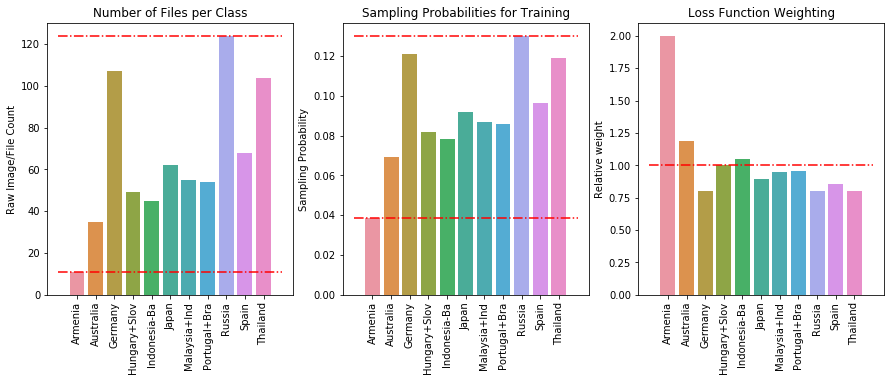

In [7]:
# Read the TrainDataInfo and confirm it worked
train_info = TrainDataInfo('train_fixed_rotation')
train_info.display_rel_counts()

In [8]:
INPUT_IMG_SIZE_3 = (299, 299, 3)
INPUT_IMG_SIZE_2 = INPUT_IMG_SIZE_3[:2]
NUM_COUNTRIES = len(train_info.country_names)
BATCH_SIZE = 16

train_utils = TrainingUtils(train_info, INPUT_IMG_SIZE_3, batch_size=BATCH_SIZE)

In [7]:
multi_out_extrafc = train_utils.create_feature_extractor_model()
multi_out_extrafc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

------
Create the pre-computed feature tables onto disk

In [10]:
# Create a set of files for each k-fold
for k in range(5):
    # Using these methods to create the generator will do sampling and augmentation
    # according to train_info sampling probabilities and ImageUtilities augment function
    print(f'Extracting features to disk for fold {k}')
    gen = train_utils.train_data_generator_disk(k, INPUT_IMG_SIZE_2)
    train_ds = train_utils.generator_to_dataset(gen, INPUT_IMG_SIZE_3, NUM_COUNTRIES, BATCH_SIZE)
    test_ds = train_utils.create_test_dataset(k, INPUT_IMG_SIZE_3, batch_size=1)
    
    out_file_prefix = f'feature_extractions/xception_with_3_inner_layers__fold_{k}'
    train_utils.extract_features_to_disk(multi_out_extrafc, train_ds, test_ds, out_file_prefix, train_repeat=6)

Extracting features to disk for fold 0
Full set of training features and labels: (3408, 4232) and (3408,)
Full set of testing features and labels: (146, 4232) and (146,)
Extracting features to disk for fold 1
Full set of training features and labels: (3414, 4232) and (3414,)
Full set of testing features and labels: (145, 4232) and (145,)
Extracting features to disk for fold 2
Full set of training features and labels: (3426, 4232) and (3426,)
Full set of testing features and labels: (143, 4232) and (143,)
Extracting features to disk for fold 3
Full set of training features and labels: (3432, 4232) and (3432,)
Full set of testing features and labels: (142, 4232) and (142,)
Extracting features to disk for fold 4
Full set of training features and labels: (3456, 4232) and (3456,)
Full set of testing features and labels: (138, 4232) and (138,)


In [9]:
# Lets confirm that the numpy files we just wrote are sane
load_fex = np.load(f'feature_extractions/xception_with_3_inner_layers__fold_0_train_features.npy')
load_lbl = np.load(f'feature_extractions/xception_with_3_inner_layers__fold_0_train_labels.npy')
print(load_fex.shape, load_lbl.shape)

(3408, 4232) (3408,)


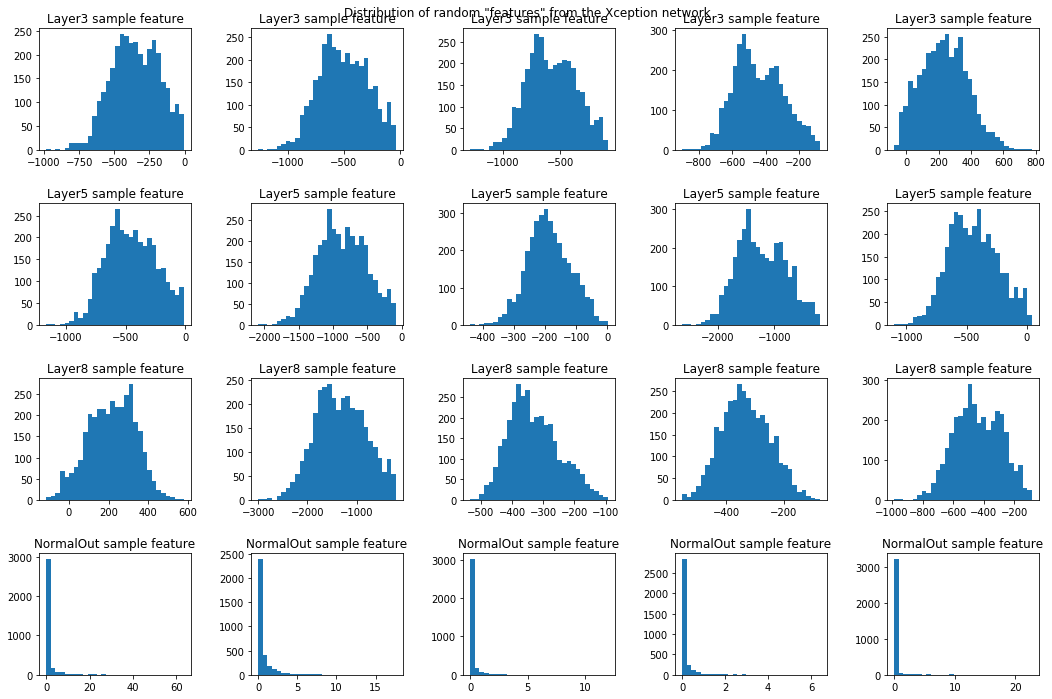

In [13]:
fig,axs = plt.subplots(4,5, figsize=(15,10))
layers = ['Layer3', 'Layer5', 'Layer8', 'NormalOut']
for r in range(4):
    for c in range(5):
        rnd_idx = np.random.choice(range(r*728, (r+1)*728))
        axs[r][c].hist(load_fex[:,rnd_idx], bins=30)
        axs[r][c].set_title(f'{layers[r]} sample feature')
fig.suptitle('Distribution of random "features" from the Xception network')
fig.tight_layout(pad=2.0)
# Wondering how well gaussian naive bayes will work with this data... 

If we were to use Naive Bayes on this data, would probably want only the intermediate layer outputs, which all look pretty Gaussian.  The normal outputs look more like one-hot features, where they are generally zero/negligible unless a particular pattern is found.

## Create Directories for Testing Final Deliverable
We create one directory of normal-orientation images, another with only rotated images, to test that it corrects the orientation properly.

In [9]:
# This creates two directories for testing the final deliverable
# The first directory is for unrotated images
# The second directory has all rotated images
from image_utilities import ImageUtilities
from tensorflow.keras.preprocessing import image as keras_preproc

for k in range(5):
    print(f'Writing images to disk for fold {k}')
    test_ds = train_utils.create_test_dataset(k, INPUT_IMG_SIZE_3, batch_size=16)
    
    out_dir_reg = f'e2e_tests/test_fold_{k}_no_clicks'
    out_dir_rot = f'e2e_tests/test_fold_{k}_rand_click'
    os.makedirs(out_dir_reg, exist_ok=True)
    os.makedirs(out_dir_rot, exist_ok=True)
    click0_ans = open(os.path.join(out_dir_reg, 'answers.csv'), 'w')
    clickN_ans = open(os.path.join(out_dir_rot, 'answers.csv'), 'w')
    
    for country, fn_list in train_info.traintest_splits[k]['test'].items():
        for fn in fn_list:
            local_fn = os.path.basename(fn)
            
            # Add country name to filename to make it easier to inspect resulting .csv
            base, ext = os.path.splitext(local_fn)
            local_fn = f'{base}_{country[:5].upper()}{ext}'
            
            click0_ans.write(f'{local_fn},{country}\n')
            clickN_ans.write(f'{local_fn},{country}\n')
            
            # Write the unrotated image
            cv2_img = cv2.imread(fn)
            cv2.imwrite(os.path.join(out_dir_reg, local_fn), cv2_img)
            
            # Write the rotated image
            rots = {0: cv2.ROTATE_90_CLOCKWISE, 1: cv2.ROTATE_90_COUNTERCLOCKWISE, 2: cv2.ROTATE_180}
            rotated_img = cv2.rotate(cv2_img, rots[np.random.choice(3)])
            cv2.imwrite(os.path.join(out_dir_rot, local_fn), rotated_img)
            
    click0_ans.close()
    clickN_ans.close()
        

Writing images to disk for fold 0
Writing images to disk for fold 1
Writing images to disk for fold 2
Writing images to disk for fold 3
Writing images to disk for fold 4
